In [1]:
using Oceananigans
using NCDatasets
using CairoMakie
using Printf

In [2]:
Ri = 0.001;

In [3]:
Nx, Nz = 64, 64
H = 10
L = 10

grid = RectilinearGrid(
    size=(Nx, Nz),
    x=(-H/2, H/2),
    z=(-L/2, L/2),
    topology=(Periodic, Flat, Bounded)
)

64×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── Periodic x ∈ [-5.0, 5.0)      regularly spaced with Δx=0.15625
├── Flat y
└── Bounded  z ∈ [-5.0, 5.0]      regularly spaced with Δz=0.15625

In [4]:
shear_flow(x, z, t) = tanh(z)

stratification(x, z, t, p) = p.h * p.Ri * tanh(z / p.h)

U = BackgroundField(shear_flow)

B = BackgroundField(stratification, parameters=(Ri=Ri, h=1.25));

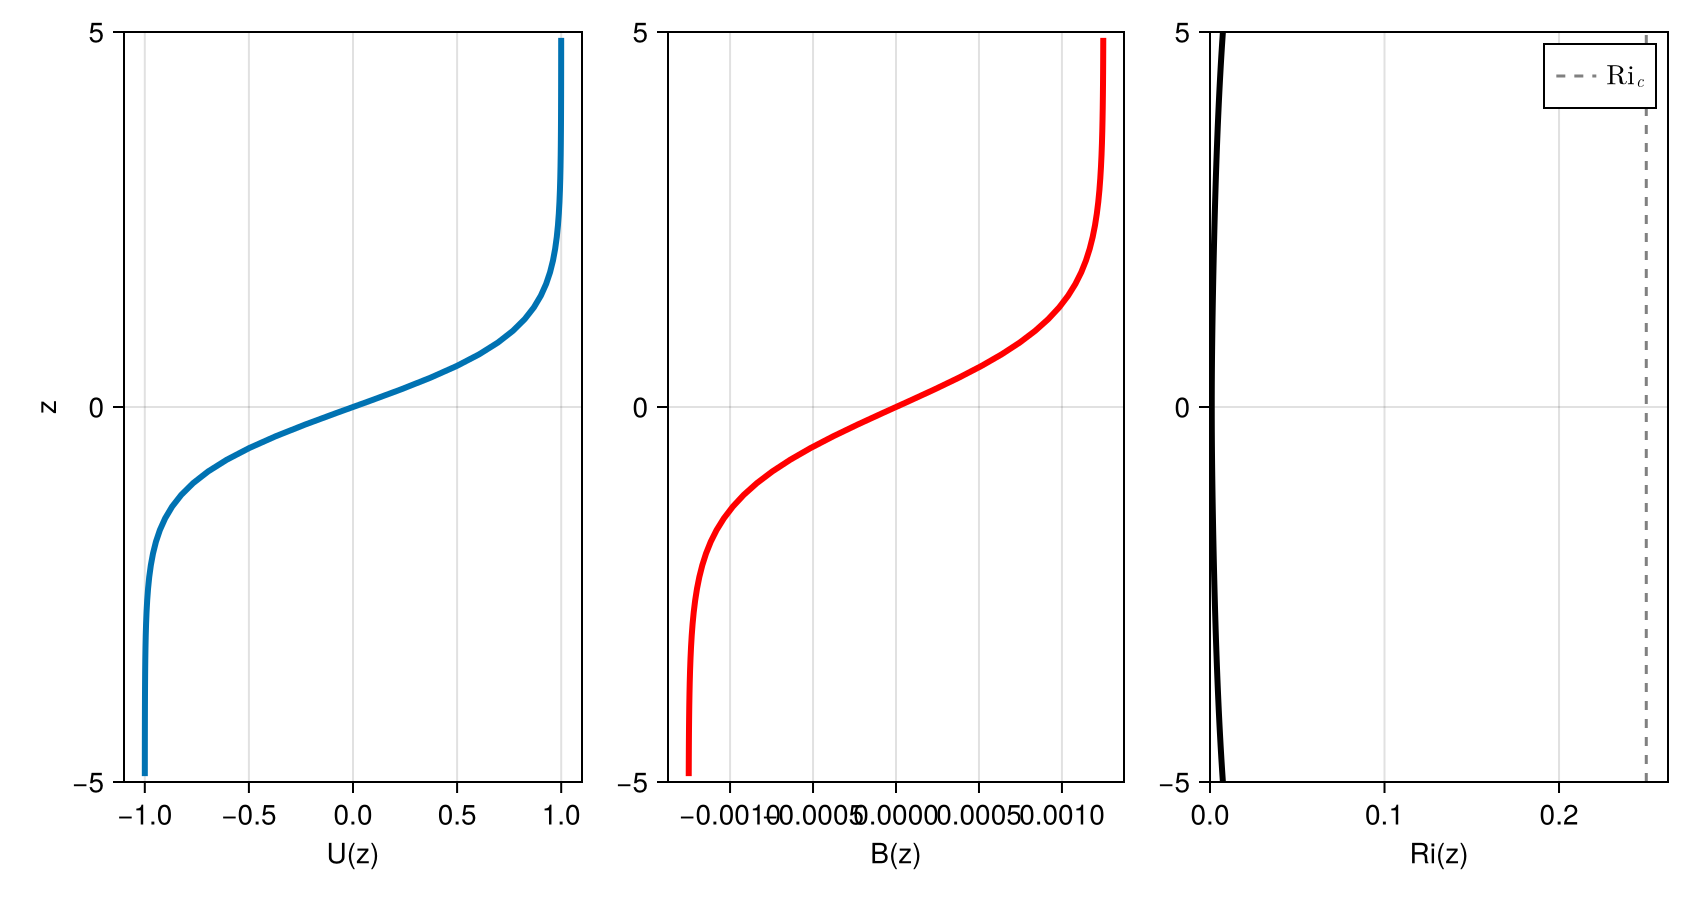

In [5]:
zF = znodes(grid, Face())
zC = znodes(grid, Center())

Ri, h = B.parameters

fig = Figure(size = (850, 450))

ax = Axis(fig[1, 1], xlabel = "U(z)", ylabel = "z", limits=((nothing, nothing), (-5, 5)))
lines!(ax, shear_flow.(0, zC, 0), zC; linewidth = 3)

ax = Axis(fig[1, 2], xlabel = "B(z)", limits=((nothing, nothing), (-5, 5)))
lines!(ax, [stratification(0, z, 0, (Ri=Ri, h=h)) for z in zC], zC; linewidth = 3, color = :red)

ax = Axis(fig[1, 3], xlabel = "Ri(z)", limits=((0, nothing), (-5, 5)))
lines!(
    ax, [Ri * sech(z / h)^2 / sech(z)^2 for z in zF], zF;
    linewidth = 3, color = :black,
) # Ri(z)= ∂_z B / (∂_z U)²; derivatives computed by hand
vlines!(ax, [0.25], linestyle=:dash, color=:gray, label=L"Ri$_{c}$") # Critical Richardson number
axislegend(ax)

fig

In [6]:
model = NonhydrostaticModel(timestepper = :RungeKutta3,
                              advection = UpwindBiasedFifthOrder(),
                                   grid = grid,
                               coriolis = nothing,
                      background_fields = (u=U, b=B),
                                closure = ScalarDiffusivity(ν=5e-5, κ=5e-5),
                               buoyancy = BuoyancyTracer(),
                                tracers = :b)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 64×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── tracers: b
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=5.0e-5, κ=(b=5.0e-5,))
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: Nothing

In [7]:
Δt = 0.2
simulation = Simulation(model, Δt=Δt, stop_iteration=2500, verbose=true)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 200 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: Inf days
├── Stop iteration : 2500.0
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [8]:
@info "Setting initial conditions"

using Random, Statistics

u, v, w = model.velocities
b = model.tracers.b
xb, yb, zb = nodes(b)
B = Field(b + model.background_fields.tracers.b)

TKE = Field(Average(1/2 * (u^2 + w^2)))

noise(x, z) = 1.e-4*randn()
set!(model, u=noise, w=noise, b=noise)

[ Info: Setting initial conditions


In [9]:
global_attributes = Dict("Ri" => Ri)

simulation.output_writers[:state] = NetCDFOutputWriter(
    model, (u=u, w=w, b=b, B=B,),
    schedule = TimeInterval(3.0),
    filename =  string("../data/raw_output/shear_instability_state_Ri=",Ri,".nc"),
    global_attributes = global_attributes,
    overwrite_existing = true
)

simulation.output_writers[:averages] = NetCDFOutputWriter(
    model, (TKE=TKE,),
    schedule = TimeInterval(1.0),
    filename = string("../data/processed_output/shear_instability_TKE_Ri=",Ri,".nc"),
    global_attributes = global_attributes,
    overwrite_existing = true
)

simulation.output_writers

OrderedCollections.OrderedDict{Symbol, Oceananigans.AbstractOutputWriter} with 2 entries:
  :state    => NetCDFOutputWriter scheduled on TimeInterval(3 seconds):…
  :averages => NetCDFOutputWriter scheduled on TimeInterval(1 second):…

In [10]:
@info "*** Running a simulation of Kelvin-Helmholtz (stratified shear) instability..."
run!(simulation)

[ Info: *** Running a simulation of Kelvin-Helmholtz (stratified shear) instability...
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (7.091 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (5.543 seconds).
[ Info: Simulation is stopping after running for 1.221 minutes.
[ Info: Model iteration 2500 equals or exceeds stop iteration 2500.


In [11]:
ds = NCDataset(simulation.output_writers[:state].filepath, "r")
show(ds)
close(ds)

Dataset: ./../data/raw_output/shear_instability_state_Ri=0.001.nc
Group: /

Dimensions
   zC = 64
   zF = 65
   xC = 64
   yF = 1
   xF = 64
   yC = 1
   time = 145

Variables
  zC   (64)
    Datatype:    Float64 (Float64)
    Dimensions:  zC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the z-direction.

  zF   (65)
    Datatype:    Float64 (Float64)
    Dimensions:  zF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the z-direction.

  xC   (64)
    Datatype:    Float64 (Float64)
    Dimensions:  xC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the x-direction.

  yF   (1)
    Datatype:    Float64 (Float64)
    Dimensions:  yF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the y-direction.

  xF   (64)
    Datatype:    Float64 (Float64)
    Dimensions

closed Dataset

In [12]:
@info "Making a neat movie of stratified shear flow..."

ds = NCDataset(simulation.output_writers[:state].filepath, "r")

times = ds["time"][:]
t_final = times[end]

n = Observable(1)

Bₙ = @lift ds["B"][:, 1, :, $n]

fig = Figure(size=(800, 600))

kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (-3, 3)), aspect=1,)

title = @lift @sprintf("buoyancy [m/s²] at t = %.2f", times[$n])

ax_B = Axis(fig[1, 1]; title = title, kwargs...)

B_lims = (-maximum(abs, ds["B"][:, 1, :, :]), maximum(abs, ds["B"][:, 1, :, :]))

hm_B = heatmap!(ax_B, xb, zb, Bₙ; colorrange = B_lims, colormap = :balance)
Colorbar(fig[1, 2], hm_B)

frames = 1:length(times)

record(fig, "../animations/shear_instability_movie.mp4", frames, framerate=8) do i
    n[] = i
end

close(ds)

[ Info: Making a neat movie of stratified shear flow...


closed Dataset

[ Info: Plotting some snapshots of the simulation at difference times...


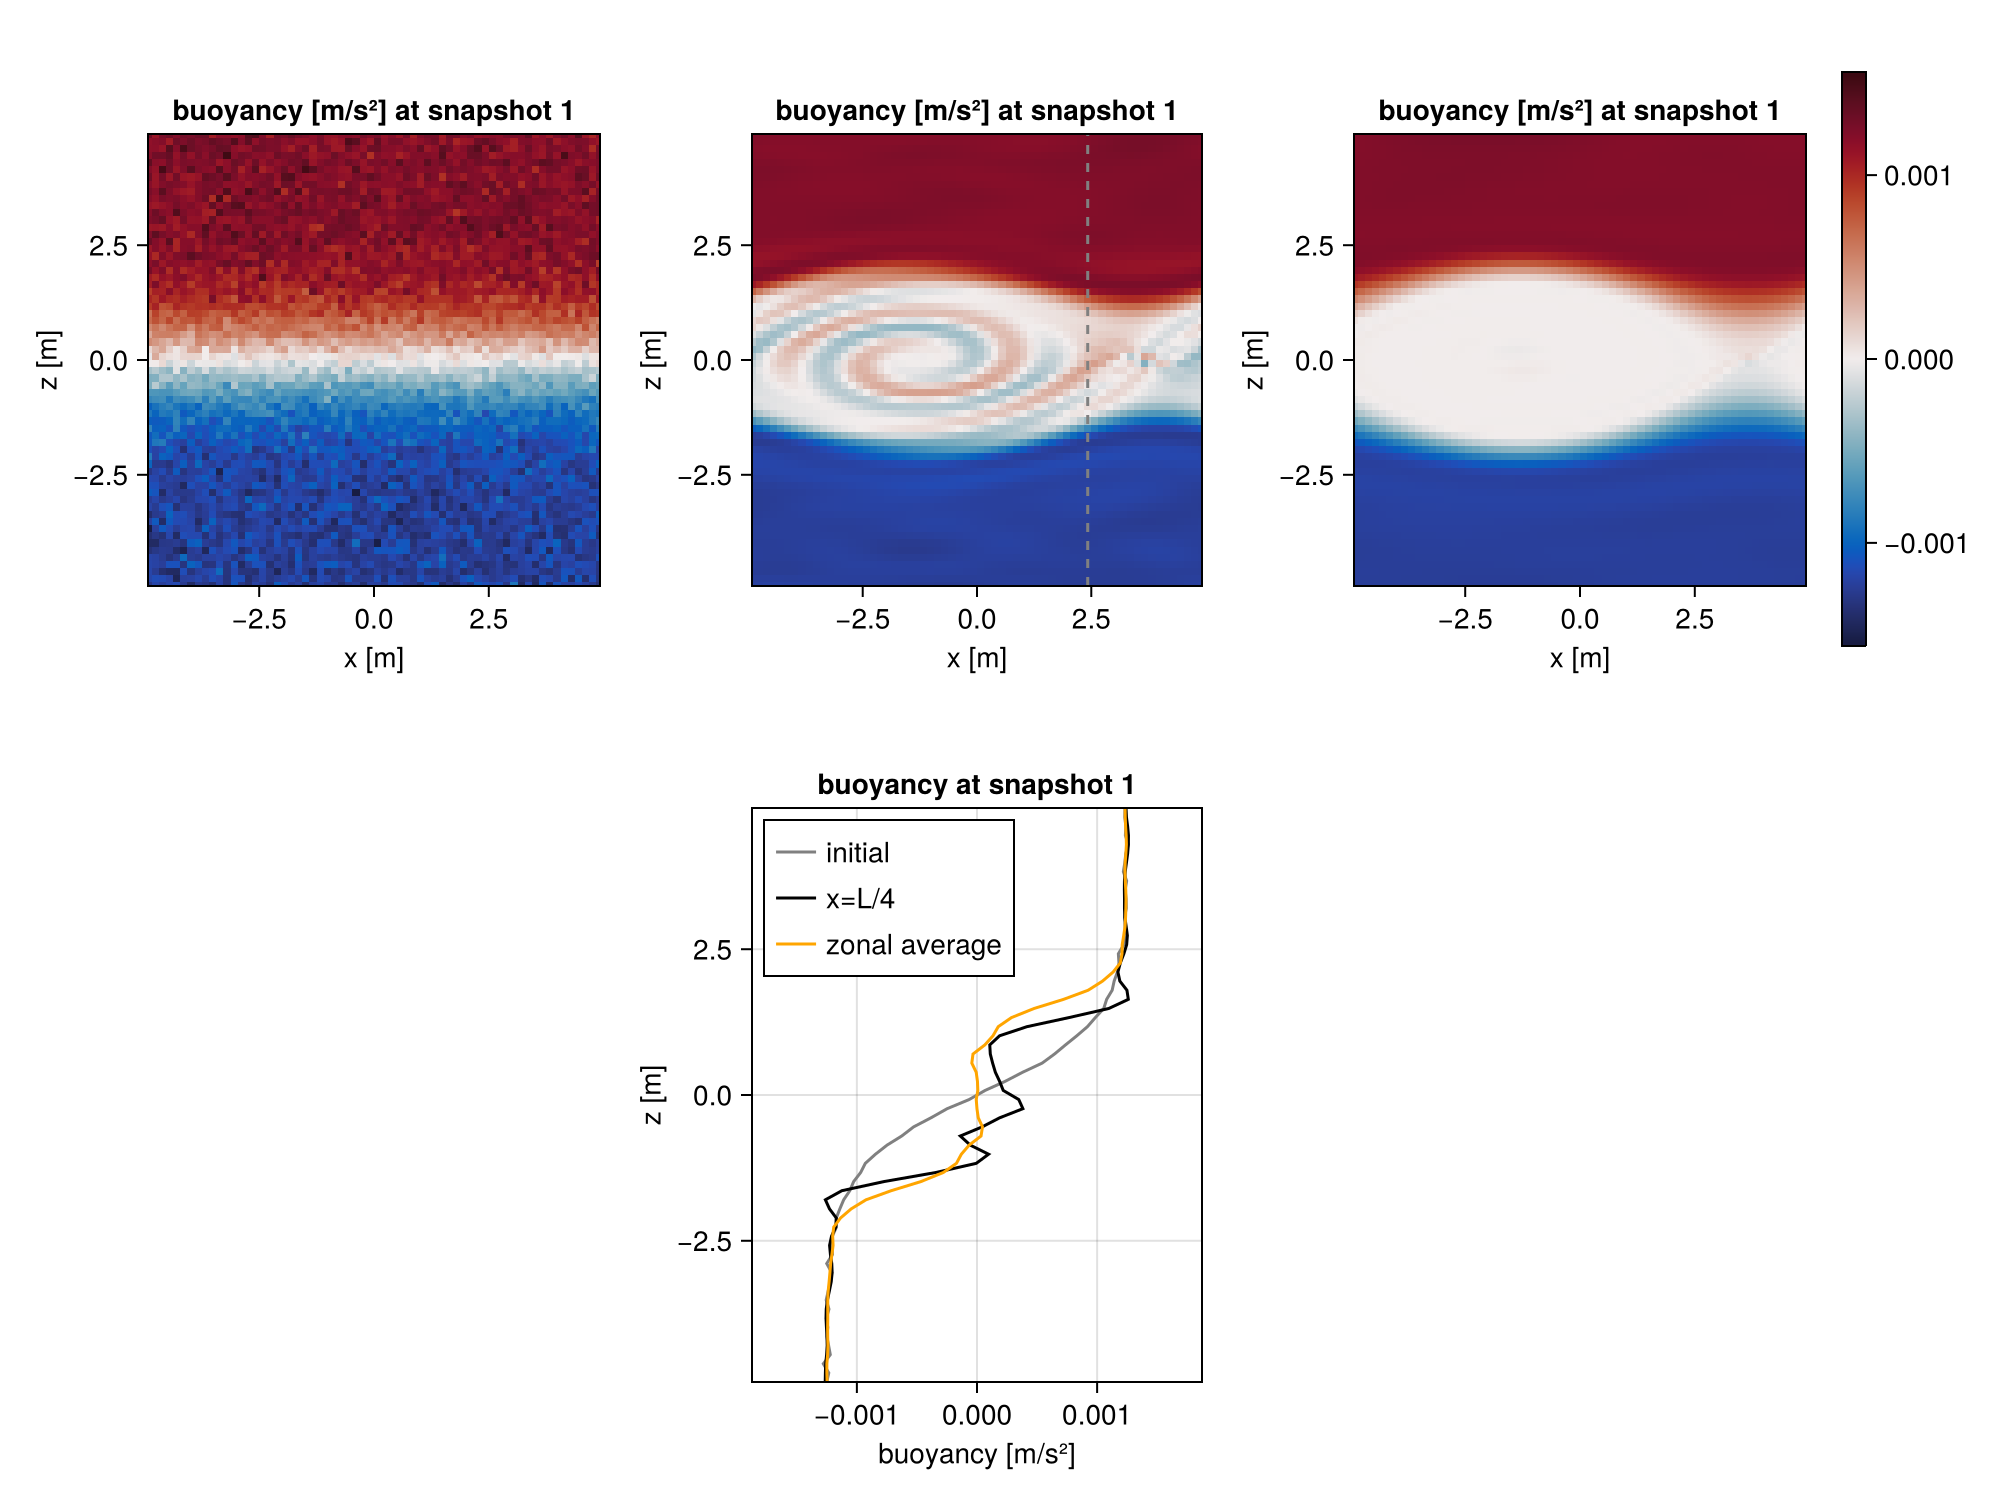

In [13]:
@info "Plotting some snapshots of the simulation at difference times..."

ds = NCDataset(simulation.output_writers[:state].filepath, "r")

fig = Figure(size=(1000, 750))
t = 1
kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (zb[1], zb[end])), aspect=1,)
ax_B = Axis(fig[1, 1]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, xb, zb, ds["B"][:,1,:,t]; colorrange = B_lims, colormap = :balance)

n = 40
ax_B = Axis(fig[1, 2]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, xb, zb, ds["B"][:,1,:,n]; colorrange = B_lims, colormap = :balance)
i = Nx÷2+Nx÷4
vlines!(ax_B, ds["xC"][i], linestyle=:dash, color=:gray)

n_end = length(ds["B"]["time"])
ax_B = Axis(fig[1, 3]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, xb, zb, ds["B"][:,1,:,n_end]; colorrange = B_lims, colormap = :balance)

ax_B = Axis(fig[2, 2]; title = string("buoyancy at snapshot ",t), xlabel="buoyancy [m/s²]", ylabel="z [m]", limits=(1.2.*B_lims, (zb[1], zb[end])))
l_B = lines!(ax_B, mean(ds["B"][:,1,:,1], dims=(1))[1,:], zb, color=:gray, label="initial")
l_B = lines!(ax_B, ds["B"][i,1,:,n], zb, label="x=L/4", color=:black)

Colorbar(fig[1, 4], hm_B)
leg = axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots.png", fig)

l_B = lines!(ax_B, mean(ds["B"][:,1,:,n], dims=(1))[1,:], zb, label="zonal average", color=:orange)
delete!(leg)
axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots_mean.png", fig)

close(ds)

fig